In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

In [95]:
# import pipeline, tfidf, countvectorizer, naive bayes, svm to classify the comments
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [96]:
train_df = pd.read_csv('../../data/clean/train.csv')
test_df = pd.read_csv('../../data/clean/test.csv')

In [97]:
X_train,y_train = train_df['text'], train_df['label']
X_test,y_test = test_df['text'], test_df['label']

In [98]:
word_count = {}
for text in train_df['text']:
    for word in text.split():
        word_count[word] = word_count.get(word, 0) + 1

word_count_df = pd.DataFrame(word_count.items(), columns=['word', 'count'])

In [99]:
vocab = set(word_count_df[word_count_df['count'] >= 5]['word'].values)

In [100]:
def report(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    plt.figure(figsize=(10,10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Naive Bayes

In [101]:
naive_bayes = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=vocab)),
    ('clf', MultinomialNB())
])

In [102]:
naive_bayes.fit(X_train, y_train)
naive_bayes.score(X_train, y_train)

0.7643350955673038

              precision    recall  f1-score   support

         NEG       0.63      0.62      0.63       334
         NEU       0.58      0.59      0.58       348
         POS       0.66      0.66      0.66       330

    accuracy                           0.62      1012
   macro avg       0.62      0.62      0.62      1012
weighted avg       0.62      0.62      0.62      1012



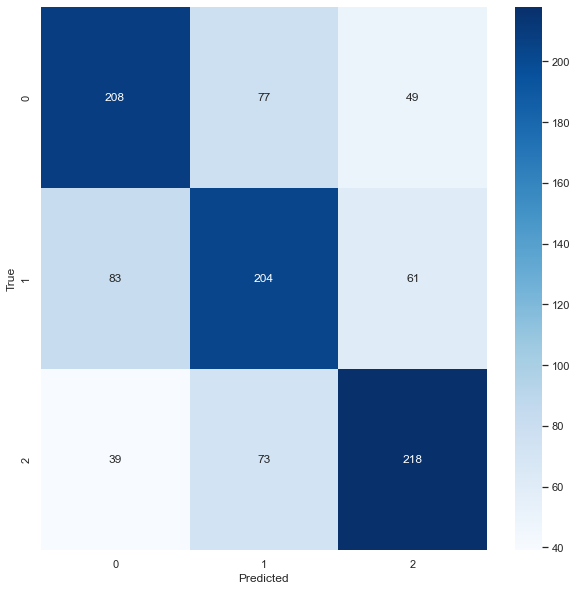

In [103]:
report(y_test, naive_bayes.predict(X_test))

Sản phẩm này chán quá ==> Naive:['NEG'], SVM:['NEG']
Đang đợi bản màu trắng, bản màu đen hết hàng ==> Naive:['POS'], SVM:['NEU']
Tôi thích sản phẩm này ==> Naive:['POS'], SVM:['POS']
Sản phẩm giá rẻ, sau một thời gian sẽ tăng giá ==> Naive:['NEU'], SVM:['NEU']
Sản phẩm này tốt ==> Naive:['POS'], SVM:['POS']
Sản phẩm này chất lượng tốt ==> Naive:['POS'], SVM:['POS']
Sản phẩm đểu ==> Naive:['NEG'], SVM:['POS']


## SVM

In [104]:
# svm with exponential kernel
svm = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=vocab)),
    ('clf', SVC(kernel='rbf'))
])

In [105]:
svm.fit(X_train, y_train)
svm.score(X_train, y_train)

0.9457096380642538

              precision    recall  f1-score   support

         NEG       0.66      0.65      0.66       334
         NEU       0.60      0.70      0.64       348
         POS       0.72      0.61      0.66       330

    accuracy                           0.65      1012
   macro avg       0.66      0.65      0.65      1012
weighted avg       0.66      0.65      0.65      1012



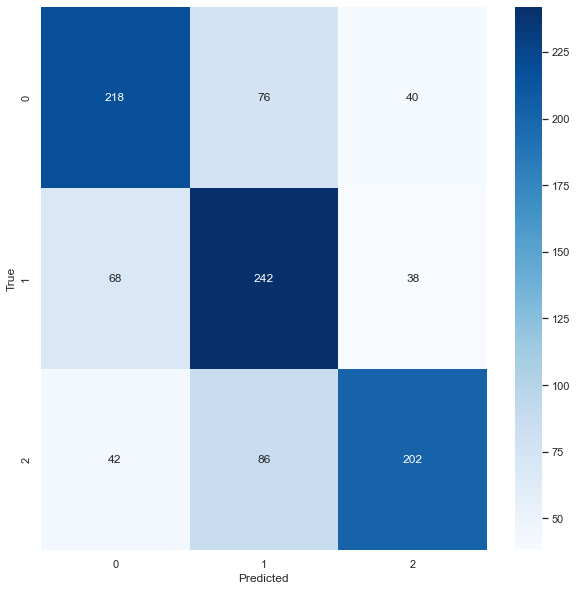

In [106]:
report(y_test, svm.predict(X_test))

XGBClassifier

In [120]:
from xgboost import XGBClassifier

In [127]:
from catboost import CatBoostClassifier

In [124]:
xgb = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=vocab)),
    ('clf', XGBClassifier())
])
y_train_ = train_df['label'].map({'NEG':0, 'NEU':1, 'POS':2})
xgb.fit(X_train, y_train_)
xgb.score(X_train, y_train_)

0.8550223668157788

              precision    recall  f1-score   support

           0       0.63      0.58      0.60       334
           1       0.55      0.65      0.59       348
           2       0.70      0.62      0.65       330

    accuracy                           0.62      1012
   macro avg       0.63      0.62      0.62      1012
weighted avg       0.62      0.62      0.62      1012



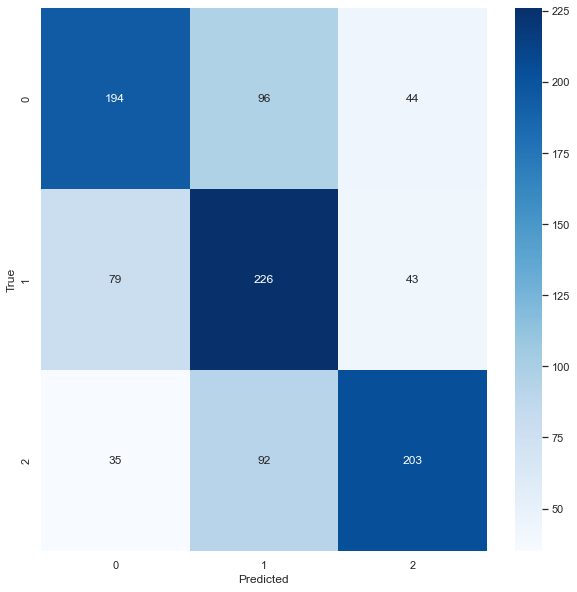

In [125]:
y_test_ = test_df['label'].map({'NEG':0, 'NEU':1, 'POS':2})
report(y_test_, xgb.predict(X_test))

In [ ]:
cat = Pipeline([
    ('tfidf', TfidfVectorizer(vocabulary=vocab)),
    ('clf', CatBoostClassifier())
])
cat.fit(X_train, y_train_)
cat.score(X_train, y_train_)

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       334
           1       0.56      0.65      0.60       348
           2       0.72      0.62      0.67       330

    accuracy                           0.63      1012
   macro avg       0.64      0.63      0.63      1012
weighted avg       0.63      0.63      0.63      1012



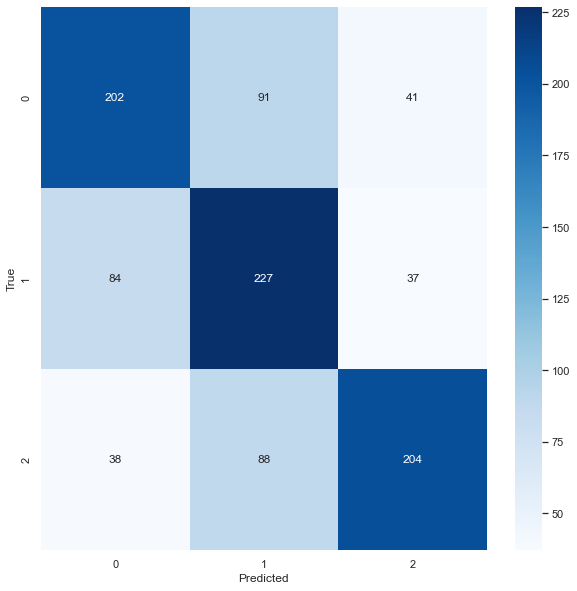

In [129]:
y_test_ = test_df['label'].map({'NEG':0, 'NEU':1, 'POS':2})
report(y_test_, cat.predict(X_test))

### 'NEG':0
### 'NEU':1
### 'POS':2

In [130]:
from underthesea import word_tokenize
# predict for some texts
texts = [
  'Sản phẩm này chán quá',
  'Đang đợi bản màu trắng, bản màu đen hết hàng',
  'Tôi thích sản phẩm này',
  'Sản phẩm giá rẻ, sau một thời gian sẽ tăng giá',
  'Sản phẩm này tốt',
  'Sản phẩm này chất lượng tốt',
  'Sản phẩm đểu',
]

for text in texts:
    text_tokenized = word_tokenize(text, format='text')
    print(f'{text}\nNaive:{naive_bayes.predict([text_tokenized])}\nSVM:{svm.predict([text_tokenized])}\nXGB:{xgb.predict([text_tokenized])}\nCat:{cat.predict([text_tokenized])}\n')

Sản phẩm này chán quá
Naive:['NEG']
SVM:['NEG']
XGB:[0]
Cat:[[0]]

Đang đợi bản màu trắng, bản màu đen hết hàng
Naive:['POS']
SVM:['NEU']
XGB:[1]
Cat:[[1]]

Tôi thích sản phẩm này
Naive:['POS']
SVM:['POS']
XGB:[1]
Cat:[[2]]

Sản phẩm giá rẻ, sau một thời gian sẽ tăng giá
Naive:['NEU']
SVM:['NEU']
XGB:[2]
Cat:[[2]]

Sản phẩm này tốt
Naive:['POS']
SVM:['POS']
XGB:[1]
Cat:[[2]]

Sản phẩm này chất lượng tốt
Naive:['POS']
SVM:['POS']
XGB:[1]
Cat:[[2]]

Sản phẩm đểu
Naive:['NEG']
SVM:['POS']
XGB:[2]
Cat:[[2]]

